In [102]:
import os
from glob import glob
from typing import Union, List

import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from tqdm import tqdm

from constants import LESION_SIZES
from utils import get_lesion_size_category

NIB_EXT = ".nii.gz"
DATA_DIR = "data/ATLAS_2/Training"

scans_filepaths = sorted(glob(os.path.join(DATA_DIR, "**/*_T1w" + NIB_EXT), recursive=True))
masks_filepaths = sorted(glob(os.path.join(DATA_DIR, "**/*T1lesion_mask" + NIB_EXT), recursive=True))

# shape: H, W, D
scans = [nib.load(filepath).get_fdata() for filepath in scans_filepaths]
masks = [nib.load(filepath).get_fdata() for filepath in masks_filepaths]

## Lesion Statistics
- Lesion volume distribution
- Lesion count per subject
- Lesion location distribution

In [140]:
def get_lesion_distribution_metadata(masks: np.ndarray):
    metadata = {
        "patients_count": 0,
        "tot_voxels": 0,
        "lesion_voxels": 0,
        "tot_slices": 0,
        "slices_with_lesions": 0,
    }

    for size in LESION_SIZES:
        metadata[size] = {
            "lesion_area": [],
            "count": 0,
        }

    for mask in tqdm(masks, desc="Getting lesion distribution metadata"):
        tot_voxels = mask.size

        slices_with_lesions = mask.any(axis=(0, 1))
        mask_lesions_only = mask[..., slices_with_lesions]

        metadata["patients_count"] += 1
        metadata["tot_voxels"] += tot_voxels
        metadata["tot_slices"] += np.sum(~slices_with_lesions)
        metadata["slices_with_lesions"] += np.sum(slices_with_lesions)

        for m in mask_lesions_only:
            category, lesion_voxels, lesion_area = get_lesion_size_category(m, return_all=True)
            metadata["lesion_voxels"] += lesion_voxels
            metadata[category]["lesion_area"].append(lesion_area)
            metadata[category]["count"] += 1

    return metadata


def plot_lesion_size_distribution(counts, labels, figsize=(8, 6)):
    assert len(counts) == len(labels), "counts and labels must have same length"

    items = zip(counts, labels)
    sorted_items = sorted(items, key=lambda x: x[0], reverse=True)
    counts, labels = zip(*sorted_items)

    colors = plt.cm.tab20.colors[:len(labels)]
    total = np.sum(counts)

    plt.figure(figsize=figsize)
    plt.bar(labels, counts, color=colors)

    for i, v in enumerate(counts):
        plt.text(i, v + 7.5, f"{v * 100 / total:.2f}%", ha="center")

    plt.ylabel("Slices Without Lesions")
    plt.xlabel("Lesion Size Categories")
    plt.xticks(rotation=45)
    plt.title("Lesion Size Distribution Across Slices")
    plt.show()


def plot_violin_lesion_size_distribution(area_counts: Union[np.ndarray, List[List[int]], List[np.ndarray]], labels, figsize=(8, 6), palette="Set3"):
    records = []
    for area_count, l in zip(area_counts, labels):
        for area in area_count:
            records.append(({"Lesion Size": l, "Lesion Area (voxels)": area}))

    df = pd.DataFrame(records, columns=["Lesion Area (voxels)", "Lesion Size"])

    plt.figure(figsize=figsize)
    sns.violinplot(data=df, x="Lesion Size", y="Lesion Area (voxels)", hue="Lesion Size", palette=palette, gap=0.5)
    sns.despine(left=True, bottom=True)


def plot_lesion_heatmap(masks: np.ndarray, figsize=(8, 6)):
    heatmap = np.zeros(masks[0].shape, dtype=np.float32)

    for mask in masks:
        heatmap += (mask > 0).astype(np.float32)

    heatmap /= len(masks)

    if heatmap.ndim == 3:
        mid_slice = heatmap.shape[-1] // 2
        heatmap = heatmap[..., mid_slice]

    plt.figure(figsize=figsize)
    plt.imshow(heatmap, cmap="hot")
    plt.colorbar(label="Frequency")
    plt.title(f"Lesion location heatmap")
    plt.axis("off")
    plt.show()

In [144]:
lesion_distribution_metadata = get_lesion_distribution_metadata(masks)
counts_across_slices = [lesion_distribution_metadata[size]["count"] for size in LESION_SIZES]
counts_per_size = [lesion_distribution_metadata[size]["lesion_area"] for size in LESION_SIZES if size != "No Lesion"]

Getting lesion distribution metadata: 100%|██████████| 5/5 [00:00<00:00, 73.73it/s]


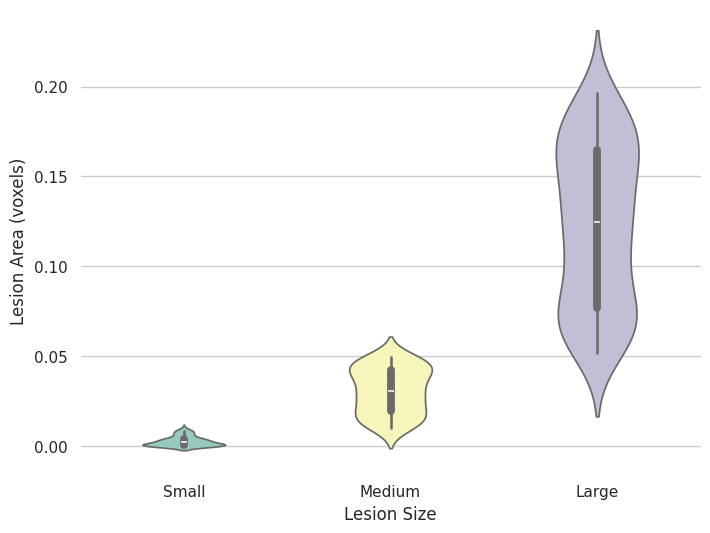

In [145]:
plot_violin_lesion_size_distribution(counts_per_size, [size for size in LESION_SIZES if size != "No Lesion"])

Total voxels: 43376445
Total lesion voxels: 322974.0
Lesion/Non-Lesion voxel ratio: 1:134.30

Total slices: 572
Total lesion slices: 373
Lesion/Non-Lesion slices ratio: 1:1.53

Average number of slices with lesions per patient: 74.60
Average number of lesions per patient: 74.60


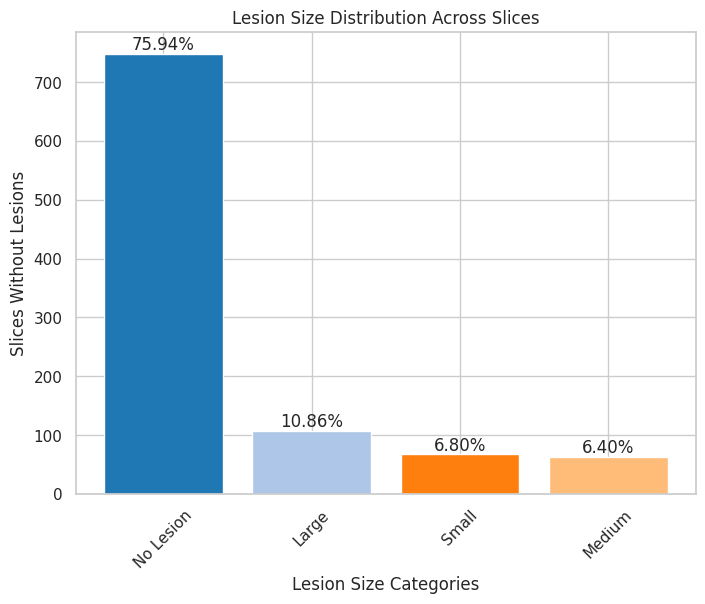

In [147]:
print(f"Total voxels: {lesion_distribution_metadata['tot_voxels']}\n"
      f"Total lesion voxels: {lesion_distribution_metadata['lesion_voxels']}\n"
      f"Lesion/Non-Lesion voxel ratio: 1:{lesion_distribution_metadata['tot_voxels'] / lesion_distribution_metadata['lesion_voxels']:.2f}\n\n"
      f"Total slices: {lesion_distribution_metadata['tot_slices']}\n"
      f"Total lesion slices: {lesion_distribution_metadata['slices_with_lesions']}\n"
      f"Lesion/Non-Lesion slices ratio: 1:{lesion_distribution_metadata['tot_slices'] / lesion_distribution_metadata['slices_with_lesions']:.2f}\n\n"
      f"Average number of slices with lesions per patient: {lesion_distribution_metadata['slices_with_lesions'] / lesion_distribution_metadata['patients_count']:.2f}\n"
      f"Average number of lesions per patient: {lesion_distribution_metadata['slices_with_lesions'] / lesion_distribution_metadata['patients_count']:.2f}")

plot_lesion_size_distribution(counts, LESION_SIZES)

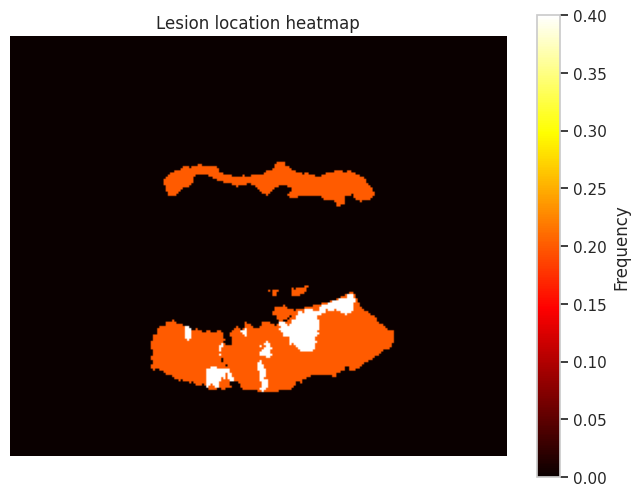

In [148]:
plot_lesion_heatmap(masks)